In [1]:
from __future__ import print_function
import torchvision
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
###############
import torchvision.models as models
import imageio
from torch import autograd
from torchvision.utils import make_grid
import imageio
from IPython.display import HTML
import time
import math
manualseed = 47
random.seed(manualseed)
torch.manual_seed(manualseed)
import torch.nn.functional as F
###############
%matplotlib inline

2 Define variables

In [2]:
workers = 2 # 数据加载器能够使用的进程数量
batch_size = 64  # 训练时的批大小

# 训练图片的大小，所有的图片都将改变到该大小
image_size = 32  # 转换器使用的大小.
nc = 1  # 训练图片的通道数，彩色图片是3
nz = 100  # 本征向量z的大小(生成器的输入大小)
ngf = 128  # 生成器中特征图个数大小
ndf = 64  # 判别器中特征图个数大小
num_epochs = 1
lr = 0.0002  # 优化器学习率
beta1 = 0.5  # Adam优化器的Beta1超参
ngpu = 1  # 可利用的GPU数量，使用0将运行在CPU模式。
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

3 创建数据集

In [3]:

################这里可不要，修改后放到下面了#################
# 创建数据集
dataset = torchvision.datasets.MNIST(root='C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\MNIST_data', train=True, transform=transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]), download=False)
# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)  #600*100*([[28*28],x])



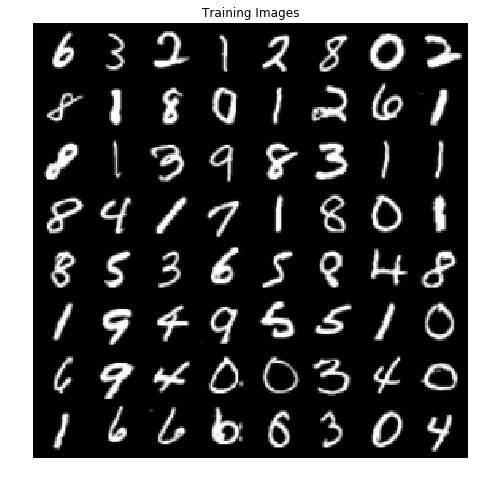

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        self.ngpu = ngpu
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(110, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x

In [6]:

# 创建生成器
netG = Generator(ngpu).to(device)

# 如果期望使用多个GPU，设置一下。
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netG.apply(weights_init)

# 输出该模型
print(netG)


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(110, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(3, ngf, 4, 2, 1, bias=False),  #这里源码的输入1通道需要改成3通道
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 16 x 16
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 8 x 8
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*4) x 4 x 4
            nn.Conv2d(ngf * 4, 11, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [8]:

# 创建判别器
netD = Discriminator(ngpu).to(device)

# 如果期望使用多GPU，设置一下
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netD.apply(weights_init)

# 输出该模型
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:

# 初始化 BCE损失函数
criterion = nn.BCELoss()
criterion_pic = nn.CrossEntropyLoss()
# 创建一个批次的本征向量用于可视化生成器训练的过程。
fixed_noise = torch.randn(64, nz + 10, 1, 1, device=device)

# 建立一个在训练中使用的真实和假的标记
real_label = 1
fake_label = 0

# 为G和D都设置Adam优化器 # 刚看到说G的lr是D的lr的2倍会好一些
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [10]:
# 训练循环

#############resnet18##############
model = models.resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
conv1 = model.conv1
conv1.stride = 1
conv1.padding = (0, 0)
conv1 = conv1.to(device)



# 保存跟踪进度的列表
img_list = []
G_losses = []
D_losses = []
iters = 0
errD_real = float(0)
print("Starting Training Loop...")
# 每个epoh
for epoch in range(num_epochs):
    # 数据加载器中的每个批次
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) 更新 D 网络: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 使用所有真实样本批次训练
        netD.zero_grad()
        # 格式化批
        real_cpu = data[0].to(device)
        ############reshape real_cpu###########
        real_cpu = torch.cat((real_cpu,real_cpu,real_cpu),1)
        
        
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device,dtype=torch.float)
        # 通过D向前传递真实批次
#         print(b_size)
        output = netD(real_cpu)
        
        output = output.view(b_size,11)
#         print(output.shape)
        # output = output.view([b_size, 11]　　　　　
        real_label_label = output[:, 0]  # 第一维就是预测是否是真实图片
        real_label_pic = output[:, 1:]  # 后十维是onehot，判断是哪个数字
        #   print(real_label_pic.shape)
        # 对所有真实样本批次计算损失
        errD_real = criterion(real_label_label, label)
        errD_real.backward(retain_graph=True)  # 连续多个backward，除了最后一个不叫retain_graph=True,其余都要加

        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()

        # 计算后向传递中D的梯度

        D_x = real_label_label.mean().item()

        ## 使用所有假样本批次训练
        # 生成本征向量批次
        #   noise = torch.randn(b_size, nz+10, 1, 1, device=device)  # 注释这行表示输入110维的noise，也就是DCGAN的输入
        noise = torch.randn(b_size, nz, device=device)

        labels_onehot = np.zeros((b_size, 10))
        labels_onehot[np.arange(b_size), data[1].numpy()] = 1
        noise = np.concatenate((noise.cpu().numpy(), labels_onehot), axis=1)
        # 每张图片是0到9之间的数字
        labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
        noise = noise.reshape([-1, 110, 1, 1])
        noise = Variable(torch.from_numpy(noise).float()).to(device)

        # 使用生成器G生成假图片
        fake = netG(noise)
        fake = torch.cat((fake,fake,fake),1)
#         print(fake.shape)
        label.fill_(fake_label)
        # 使用判别器分类所有的假批次样本
        output = netD(fake.detach())
        # 计算判别器D的损失对所有的假样本批次
        #         output = output.view([b_size, 11])
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errD_fake = criterion(real_label_label, label)
        # 对这个批次计算梯度
        errD_fake.backward(retain_graph=True)
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()
        D_G_z1 = real_label_label.mean().item()
        # 把所有真样本和假样本批次的梯度加起来
        errD = errD_real + errD_fake + errD_fake_pic
        # 更新判别器D
        optimizerD.step()

        ############################
        # (2) 更新 G 网络: 最大化 log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 假样本的标签对于生成器成本是真的
        # 因为我们之更新了D，通过D执行所有假样本批次的正向传递
        output = netD(fake).view(-1)
        # 基于这个输出计算G的损失
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errG = criterion(real_label_label, label)
        # 为生成器计算梯度
        errG.backward(retain_graph=True)
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()
        D_G_z2 = output.mean().item()
        # 更新生成器G
        optimizerG.step()

        # 输出训练状态
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 为以后画损失图，保存损失
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 检查生成器generator做了什么，通过保存的fixed_noise通过G的输出
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Congratulations! Training Finished!")

Starting Training Loop...
[0/1][0/938]	Loss_D: 4.1928	Loss_G: 3.2051	D(x): 0.3368	D(G(z)): 0.4008 / 0.4332
[0/1][50/938]	Loss_D: 2.7115	Loss_G: 23.3546	D(x): 0.9876	D(G(z)): 0.3171 / 0.0493
[0/1][100/938]	Loss_D: 2.8278	Loss_G: 6.1410	D(x): 0.7471	D(G(z)): 0.0157 / 0.0538
[0/1][150/938]	Loss_D: 2.5859	Loss_G: 4.2735	D(x): 0.9471	D(G(z)): 0.1715 / 0.1062
[0/1][200/938]	Loss_D: 2.6883	Loss_G: 3.2442	D(x): 0.8236	D(G(z)): 0.0767 / 0.1100
[0/1][250/938]	Loss_D: 3.0044	Loss_G: 4.6080	D(x): 0.7501	D(G(z)): 0.1636 / 0.1349
[0/1][300/938]	Loss_D: 2.7852	Loss_G: 3.7720	D(x): 0.8852	D(G(z)): 0.2645 / 0.1350
[0/1][350/938]	Loss_D: 3.4549	Loss_G: 0.3725	D(x): 0.3744	D(G(z)): 0.0186 / 0.1835
[0/1][400/938]	Loss_D: 2.8698	Loss_G: 1.0558	D(x): 0.6092	D(G(z)): 0.0565 / 0.1915
[0/1][450/938]	Loss_D: 3.1623	Loss_G: 4.8118	D(x): 0.9720	D(G(z)): 0.5668 / 0.1223
[0/1][500/938]	Loss_D: 2.8428	Loss_G: 3.5567	D(x): 0.9122	D(G(z)): 0.4160 / 0.1693
[0/1][550/938]	Loss_D: 3.1977	Loss_G: 1.8616	D(x): 0.4322	D(G(z

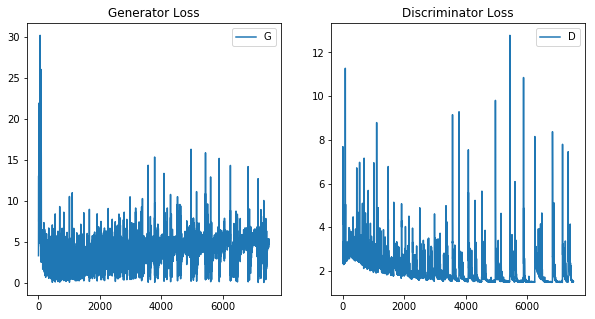

In [13]:
#Draw Losses
# 对照组
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Generator Loss")
plt.plot(G_losses,label="G")
plt.legend()
plt.subplot(1,2,2)
plt.title("Discriminator Loss")
plt.plot(D_losses,label="D")
# plt.plot(D_penalties,label="D_penalty")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
plt.legend()
plt.show()

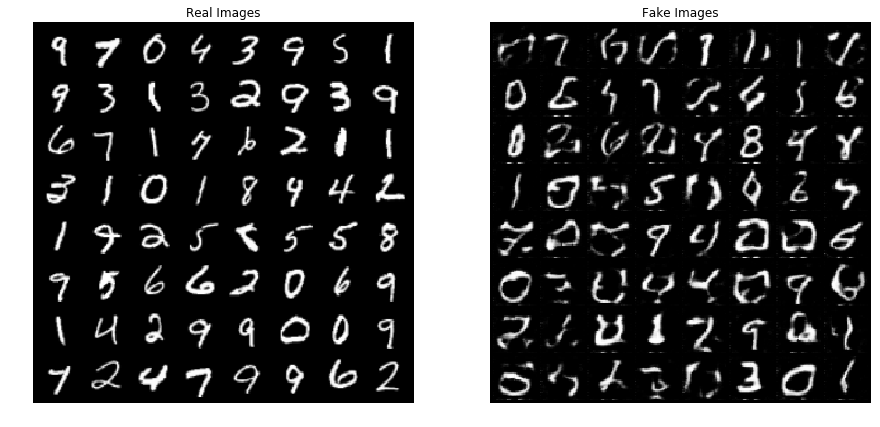

In [27]:
# 从数据加载器中获取一批真实图像
real_batch = next(iter(dataloader))

# 画出真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 画出来自最后一次训练的假图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


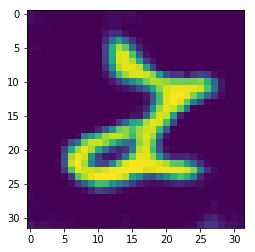

In [51]:
torch.save(netG.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Generator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netG_params.pkl")
torch.save(netD.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Discriminator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netD_params.pkl")
noise = torch.randn(b_size, nz, device=device)
        
labels_onehot = np.zeros((b_size,10))
labels_onehot[np.arange(b_size),2]=1 # 这个9换成想生成的数字
noise=np.concatenate((noise.cpu().numpy(), labels_onehot),axis=1)
# 每张图片是0到9之间的数字
labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
noise=noise.reshape([-1, 110, 1, 1])
# print(noise.shape)
noise=Variable(torch.from_numpy(noise).float()).to(device)

# 使用生成器G生成假图片
fake = netG(noise)
# fake = torch.squeeze((fake),0)
# print(fake.shape)
plt.imshow(fake.cpu().detach().numpy()[5][0])